In [1]:
# importing packages 
import numpy as np
import emcee
import corner

from scipy.optimize import least_squares
from matplotlib import pyplot as plt
from matplotlib import rcParams

%config InlineBackend.figure_format = "retina"

rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
#rcParams["font.size"] = 5


# importing functions
from functions_part2 import E_from_M
from functions_part2 import generate_pm_signal
from functions_part2 import generate_parallax_signal
from functions_part2 import thiele_innes
from functions_part2 import generate_planet_signal
from functions_part2 import generate_astrometry_signal

# unit conversion 
rad_mas = 206264806

# times 
times = np.linspace(0, 4.2, 20)

#a_hat = 8.215324703170904e-10

This function takes in pars (parameters) and times and returns the proper motion, parallax, planetary and total singal 

In [2]:
# function takes in paraneters 
def func(pars, times, a_earth = 1):
    alpha, delta, mu_alpha, mu_delta, parallax, omega, Omega, inc, e, a_AU, P_orb, t_peri = pars
    
    a_hat = 0.014116666278885887*a_AU*parallax  # a_hat is not defined correctly
    
    prop_mot_ra, prop_mot_dec = generate_pm_signal(alpha, delta, mu_alpha, mu_delta, times)

    parallax_ra, parallax_dec = generate_parallax_signal(alpha, delta, parallax, times)
    
    planetary_ra, planetary_dec = generate_planet_signal(alpha, delta, omega, Omega, inc, a_AU, parallax, P_orb, t_peri, e, times)
    
    signal_ra  = prop_mot_ra  + parallax_ra  + planetary_ra
    signal_dec = prop_mot_dec + parallax_dec + planetary_dec
    
    return(prop_mot_ra, parallax_ra, planetary_ra, signal_ra, prop_mot_dec, parallax_dec, planetary_dec, signal_dec)

This function takes in parameters, an error and xy data and returns the normalized residuals 

In [32]:
def normalized_residuals(pars, sigma, ra_obs, dec_obs):
    
    print(pars)
    _, _, _, ra_pred, _, _, _, dec_pred = func(pars, times)
    
    d_ra  = ra_obs  - ra_pred
    d_dec = dec_obs - dec_pred
    
    #if 1-pars[8]**2 < 0:
    #print("1-e^2 = ", 1-pars[8]**2)
    
    return np.concatenate((d_ra/sigma, d_dec/sigma))

Setting the true parameters 

In [33]:
alpha_true = 0.7853981641246757
delta_true = 0.7853981637587035
mu_alpha_true = 2.3084641853871365e-07
mu_delta_true = 1.770935480191023e-07
parallax_true = 9.699321049402031e-08
omega_true     = 2
Omega_true     = 1
inc_true       = 0.2
e_true = 0.2
a_AU_true      = 0.6 
P_orb_true = 0.46146592515998475
t_peri_true = 0 


truepars = np.array((alpha_true, delta_true, mu_alpha_true, mu_delta_true, parallax_true, omega_true, Omega_true, inc_true, e_true, a_AU_true, P_orb_true, t_peri_true))

Using true parameters to create true data and adding some noise/error to that data to make the observed data 

In [34]:
pm_ra_true, prlx_ra_true, true_plnt_ra, true_ra, pm_dec_true, prlx_dec_true, true_plnt_dec, true_dec = func(truepars, times)

sigma_err = (1e-5*np.pi/180/60/60)*5

# yobs is equal to ytrue + some noise
ra_obs  = true_ra   +  np.random.normal(0, sigma_err, len(true_ra)) 
dec_obs = true_dec  +  np.random.normal(0, sigma_err, len(true_dec)) 

Making a guess for the parameteres based on the true data plus some random constant within 0-0.01

In [35]:
np.random.seed(22)
constant = np.random.uniform(0,0.01)
guess = truepars + constant

Using least_squares to do a least squares fit using the observed data and guess parameters to calculate the parameters (result_LS.x) which are then using in func to create data 

In [36]:
# LS fit
result_LS = least_squares(normalized_residuals, guess, args=(sigma_err, ra_obs, dec_obs)) 

# data from best fit 
_, _, best_plnt_ra, best_ra, _, _, best_plnt_dec, best_dec = func(result_LS.x, times)

[0.78748277 0.78748277 0.00208484 0.00208478 0.0020847  2.00208461
 1.00208461 0.20208461 0.20208461 0.60208461 0.46355053 0.00208461]
[0.78748278 0.78748277 0.00208484 0.00208478 0.0020847  2.00208461
 1.00208461 0.20208461 0.20208461 0.60208461 0.46355053 0.00208461]
[0.78748277 0.78748278 0.00208484 0.00208478 0.0020847  2.00208461
 1.00208461 0.20208461 0.20208461 0.60208461 0.46355053 0.00208461]
[0.78748277 0.78748277 0.00208485 0.00208478 0.0020847  2.00208461
 1.00208461 0.20208461 0.20208461 0.60208461 0.46355053 0.00208461]
[0.78748277 0.78748277 0.00208484 0.0020848  0.0020847  2.00208461
 1.00208461 0.20208461 0.20208461 0.60208461 0.46355053 0.00208461]
[0.78748277 0.78748277 0.00208484 0.00208478 0.00208472 2.00208461
 1.00208461 0.20208461 0.20208461 0.60208461 0.46355053 0.00208461]
[0.78748277 0.78748277 0.00208484 0.00208478 0.0020847  2.00208464
 1.00208461 0.20208461 0.20208461 0.60208461 0.46355053 0.00208461]
[0.78748277 0.78748277 0.00208484 0.00208478 0.0020847 

Printing the parameters calculated in result_LS and plotting the true and best data for planetary and full signal

Lest-squares estimates:
alpha = 0.7853981641114794
delta = 0.7853981635629321
mu_alpha = 2.3085810912056044e-07
mu_delta = 1.7714750750639783e-07
parallax = 9.697972141383626e-08
omega = 2.5350860345563335
Omega = 0.1744675256066861
inc = 0.23782361318316417
e = 0.17822751437642856
a_AU = 0.5754285346952236
P_orb = 0.4601410628894799
t_peri = -0.015360688512904216


Text(0.5, 1.0, 'Dec Signal vs Time')

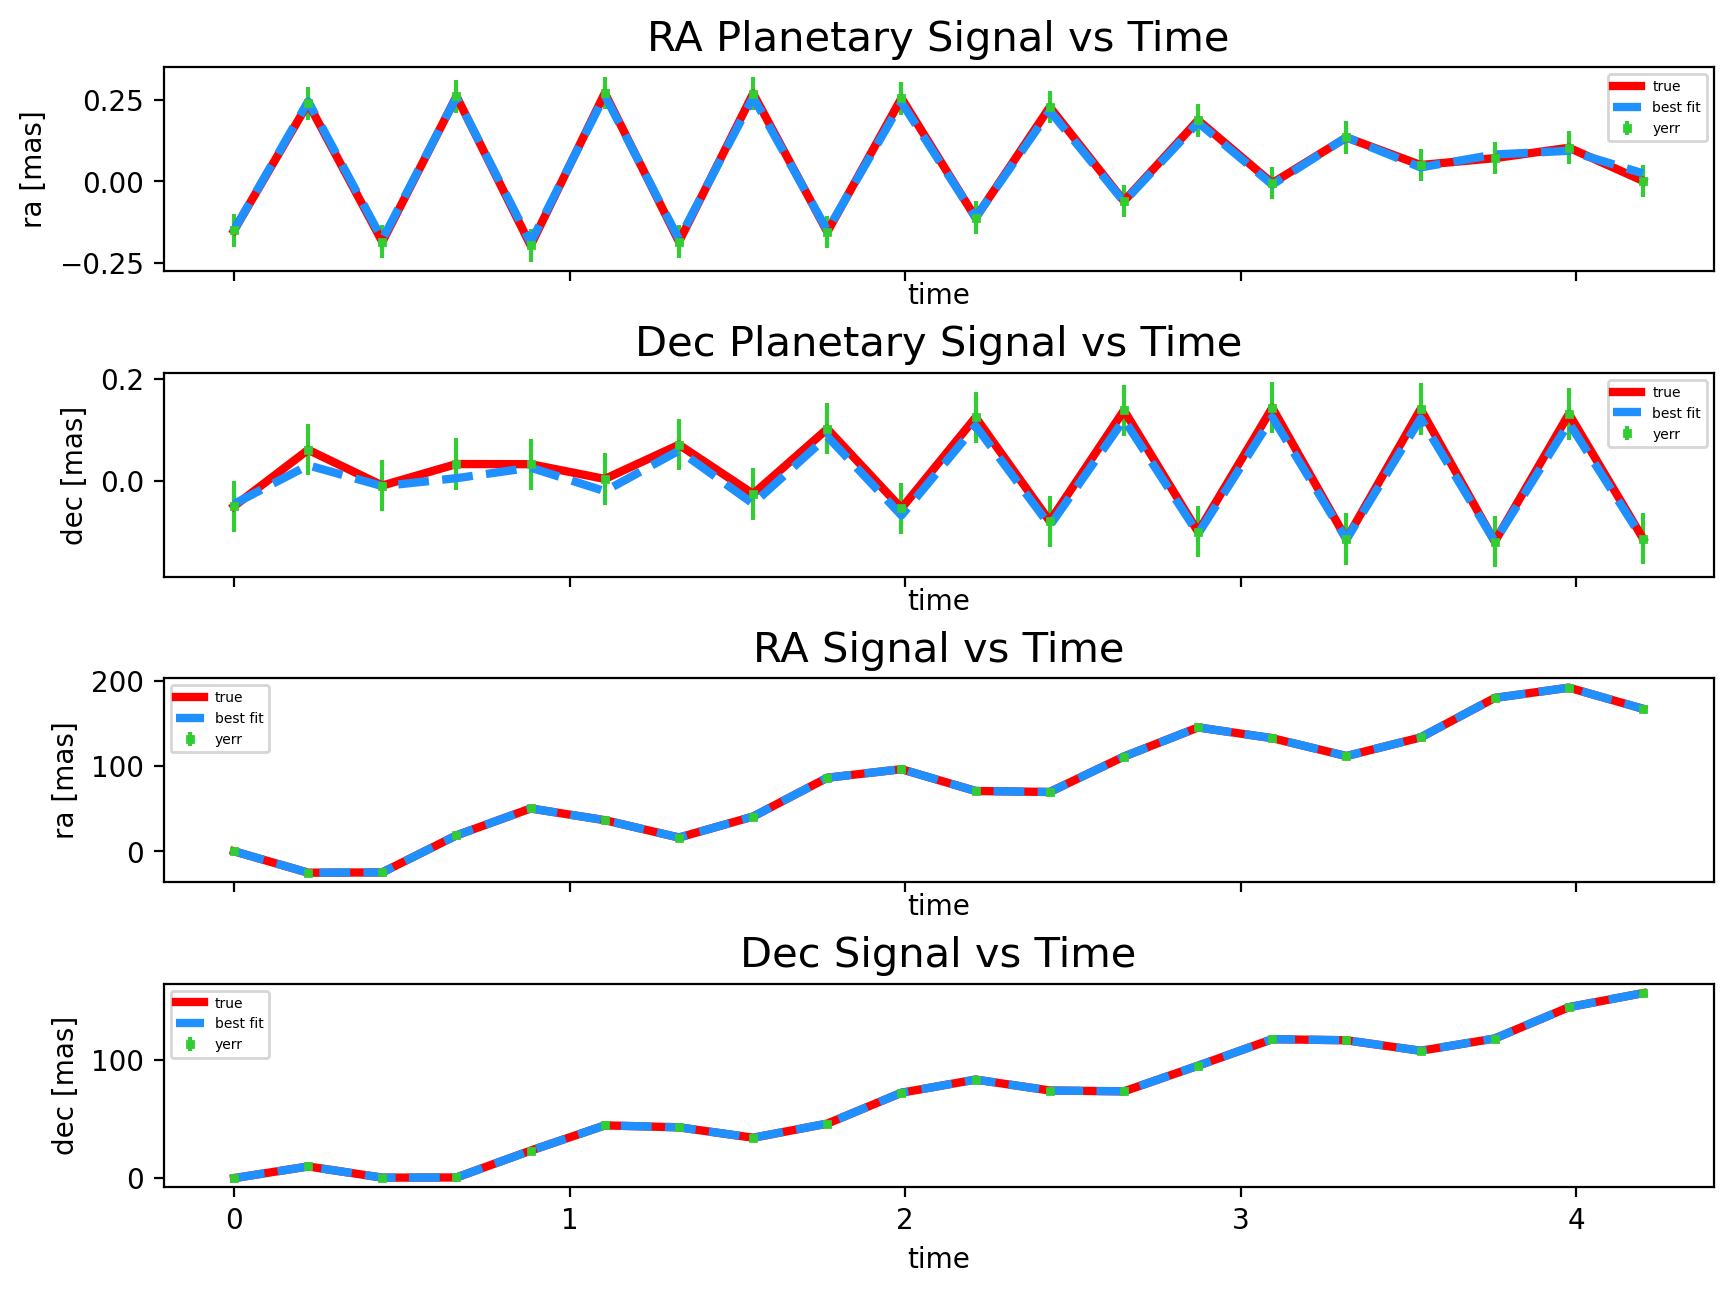

In [37]:
# printing the parameters that the LS fit calculated 
parameters = ['alpha', 'delta', 'mu_alpha', 'mu_delta', 'parallax', 'omega', 'Omega', 'inc', 'e', 'a_AU', 'P_orb', 't_peri']
print("Lest-squares estimates:")
for i in range(0, len(parameters)):
    print(parameters[i], '=', result_LS.x[i])

fig, ax = plt.subplots(4, 1, figsize=(10, 7), sharex=True)

plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.5)

ax[0].errorbar(times, (true_plnt_ra)*rad_mas, yerr=sigma_err*rad_mas, fmt="s", markersize=2, color='limegreen', label='yerr')
ax[0].plot(times, (true_plnt_ra)*rad_mas, lw=3, color='red', label='true')
ax[0].plot(times, (best_plnt_ra)*rad_mas, lw=3, color='dodgerblue', label='best fit', ls='--')
ax[0].legend(fontsize=5)
ax[0].set_xlabel("time", fontsize = 10)
ax[0].set_ylabel("ra [mas]", fontsize = 10)
ax[0].set_title("RA Planetary Signal vs Time", fontsize = 15)

ax[1].errorbar(times, (true_plnt_dec)*rad_mas, yerr=sigma_err*rad_mas, fmt="s", markersize=2, color='limegreen', label='yerr')
ax[1].plot(times, (true_plnt_dec)*rad_mas, lw=3, color='red', label='true')
ax[1].plot(times, (best_plnt_dec)*rad_mas, lw=3, color='dodgerblue', label='best fit', ls='--', )
ax[1].legend(fontsize=5)
ax[1].set_xlabel("time", fontsize = 10)
ax[1].set_ylabel("dec [mas]", fontsize = 10)
ax[1].set_title("Dec Planetary Signal vs Time", fontsize = 15)

ax[2].errorbar(times, (true_ra-true_ra[0])*rad_mas, yerr=sigma_err*rad_mas, fmt="s", markersize=2, color='limegreen', label='yerr')
ax[2].plot(times, (true_ra-true_ra[0])*rad_mas, lw=3, color='red', label='true')
ax[2].plot(times, (best_ra-best_ra[0])*rad_mas, lw=3, color='dodgerblue', label='best fit', ls='--')
ax[2].legend(fontsize=5)
ax[2].set_xlabel("time", fontsize = 10)
ax[2].set_ylabel("ra [mas]", fontsize = 10)
ax[2].set_title("RA Signal vs Time", fontsize = 15)

ax[3].errorbar(times, (true_dec-true_dec[0])*rad_mas, yerr=sigma_err*rad_mas, fmt="s", markersize=2, color='limegreen', label='yerr')
ax[3].plot(times, (true_dec-true_dec[0])*rad_mas, lw=3, color='red', label='true')
ax[3].plot(times, (best_dec-best_dec[0])*rad_mas, lw=3, color='dodgerblue', label='best fit', ls='--', )
ax[3].legend(fontsize=5)
ax[3].set_xlabel("time", fontsize = 10)
ax[3].set_ylabel("dec [mas]", fontsize = 10)
ax[3].set_title("Dec Signal vs Time", fontsize = 15)

### Maximum likelihood estimation 

In [38]:
def log_likelihood(pars, x, y, yerr):
    
    values_list = normalized_residuals(pars, yerr, x, y)
    
    return -0.5*(values_list @ values_list)

In [39]:
# had to pick a seed that does not return a negative e value 
np.random.seed(3)
initial = truepars + 0.1 * np.random.randn(12)

result_ML = least_squares(normalized_residuals, initial, args=(sigma_err, true_ra, true_dec))

_,_,_, ML_ra,_,_,_, ML_dec = func(result_ML.x, times)

[ 0.96426101  0.82904915  0.00964998 -0.18634909 -0.02773872  1.9645241
  0.99172585  0.13729993  0.19561818  0.5522782   0.33007945  0.08846224]
[ 0.96426103  0.82904915  0.00964998 -0.18634909 -0.02773872  1.9645241
  0.99172585  0.13729993  0.19561818  0.5522782   0.33007945  0.08846224]
[ 0.96426101  0.82904916  0.00964998 -0.18634909 -0.02773872  1.9645241
  0.99172585  0.13729993  0.19561818  0.5522782   0.33007945  0.08846224]
[ 0.96426101  0.82904915  0.00964999 -0.18634909 -0.02773872  1.9645241
  0.99172585  0.13729993  0.19561818  0.5522782   0.33007945  0.08846224]
[ 0.96426101  0.82904915  0.00964998 -0.18634911 -0.02773872  1.9645241
  0.99172585  0.13729993  0.19561818  0.5522782   0.33007945  0.08846224]
[ 0.96426101  0.82904915  0.00964998 -0.18634909 -0.02773874  1.9645241
  0.99172585  0.13729993  0.19561818  0.5522782   0.33007945  0.08846224]
[ 0.96426101  0.82904915  0.00964998 -0.18634909 -0.02773872  1.96452413
  0.99172585  0.13729993  0.19561818  0.5522782   0

/Users/audreyburggraf/Desktop/CITA/CTA200H/PROJECT/functions_part2.py:60: RuntimeWarning: invalid value encountered in sqrt
  Y = np.sqrt((1-e**2))*sin(E)



[ 7.85398164e-01  7.85398164e-01  2.30923686e-07  1.91967846e-07
  9.69581071e-08  1.15242245e+00  1.41944424e+00  1.55992415e+00
  9.42634917e-01  3.59377011e-01  3.50671566e-01 -4.95062851e-02]
[ 7.85398164e-01  7.85398164e-01  2.30923686e-07  1.77066685e-07
  1.11859268e-07  1.15242245e+00  1.41944424e+00  1.55992415e+00
  9.42634917e-01  3.59377011e-01  3.50671566e-01 -4.95062851e-02]
[ 7.85398164e-01  7.85398164e-01  2.30923686e-07  1.77066685e-07
  9.69581071e-08  1.15242246e+00  1.41944424e+00  1.55992415e+00
  9.42634917e-01  3.59377011e-01  3.50671566e-01 -4.95062851e-02]
[ 7.85398164e-01  7.85398164e-01  2.30923686e-07  1.77066685e-07
  9.69581071e-08  1.15242245e+00  1.41944426e+00  1.55992415e+00
  9.42634917e-01  3.59377011e-01  3.50671566e-01 -4.95062851e-02]
[ 7.85398164e-01  7.85398164e-01  2.30923686e-07  1.77066685e-07
  9.69581071e-08  1.15242245e+00  1.41944424e+00  1.55992417e+00
  9.42634917e-01  3.59377011e-01  3.50671566e-01 -4.95062851e-02]
[ 7.85398164e-01  7

print the parameters the maximum likelihood estimate found and plot 

Maximum likelihood estimates:
alpha = 0.785
delta = 0.785
mu_alpha = 0.000
mu_delta = 0.000
parallax = 0.000
omega = 1.152
Omega = 1.419
inc = 1.560
e = 0.943
a_AU = 0.359
P_orb = 0.351
t_peri = -0.050


Text(0.5, 1.0, 'Dec Signal vs Time')

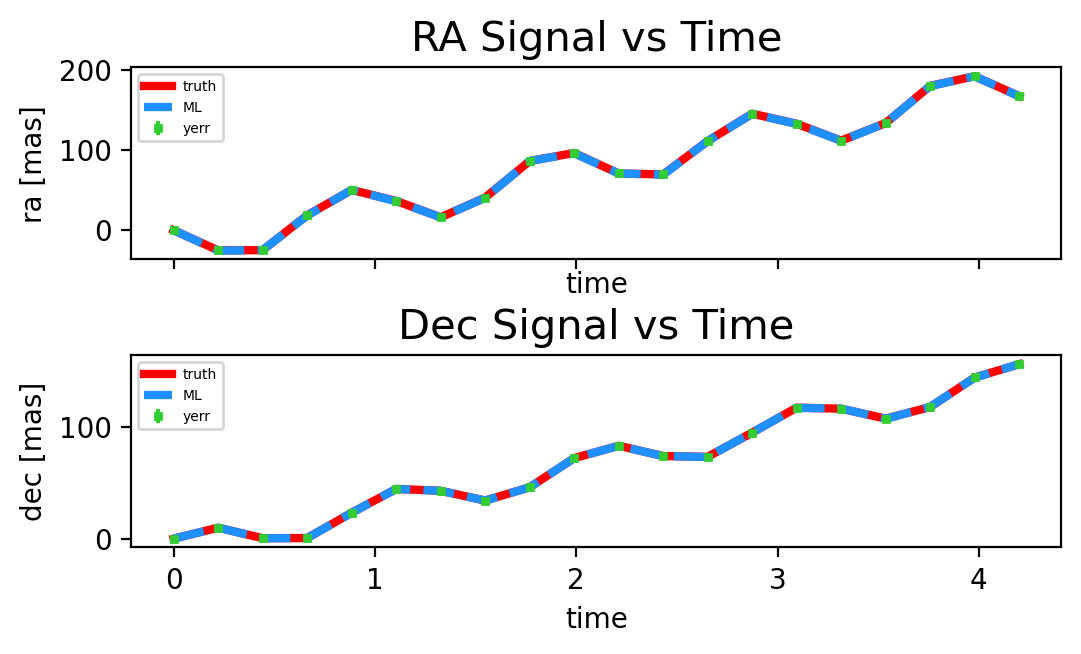

In [11]:
print("Maximum likelihood estimates:")
for i in range(0, len(parameters)):
    print(parameters[i], '= {0:.3f}'.format(result_ML.x[i]))
    
fig, ax = plt.subplots(2,1, figsize=(6, 3), sharex=True)
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.5)

ax[0].errorbar(times, 
               (true_ra-true_ra[0])*rad_mas, 
               yerr=sigma_err*rad_mas, 
               fmt="s", 
               markersize=2, 
               color='limegreen',
               label='yerr')

ax[0].plot(times, 
           (true_ra-true_ra[0])*rad_mas, 
           lw=3, color='red', 
           label='truth')

ax[0].plot(times, 
           (ML_ra-ML_ra[0])*rad_mas, 
           lw=3, 
           color='dodgerblue',
           ls='--',
           label='ML')

ax[0].legend(fontsize=5)
ax[0].set_xlabel("time", fontsize = 10)
ax[0].set_ylabel("ra [mas]", fontsize = 10)
ax[0].set_title("RA Signal vs Time", fontsize = 15)


ax[1].errorbar(times, 
               (true_dec-true_dec[0])*rad_mas, 
               yerr=sigma_err*rad_mas, 
               fmt="s", 
               markersize=2, 
               color='limegreen',
               label='yerr')

ax[1].plot(times, 
           (true_dec-true_dec[0])*rad_mas, 
           lw=3, 
           color='red',
           label='truth')

ax[1].plot(times, 
           (ML_dec-ML_dec[0])*rad_mas, 
           lw=3, 
           color='dodgerblue',
           ls='--',
           label='ML')

ax[1].legend(fontsize=5)
ax[1].set_xlabel("time", fontsize = 10)
ax[1].set_ylabel("dec [mas]", fontsize = 10)
ax[1].set_title("Dec Signal vs Time", fontsize = 15)

### Marginalization & uncertainty estimation

Function takes in parameters, if they are within certain bounds it will either return 0 or -$\infty$

In [12]:
def log_prior(pars):
    if np.alltrue(-10<pars) and np.alltrue(pars < 10):
        return 0.0
    return -np.inf 

Fucntion takes in parameters, x aand y data and y error and if log_prior(pars) is not finite it will return $-\infty$ and if it is finite it will return $log\_prior(pars)+log\_likelihood(pars, x, y, yerr)$

In [13]:
def log_probability(pars, x, y, yerr):
    lp = log_prior(pars)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(pars, x, y, yerr)

pos is an array of the parameters found in the ML fit plus some number with 32 different numbers

In [14]:
pos = result_ML.x + 1e-4 * np.random.randn(32, 12)
nwalkers, ndim = pos.shape

initials_good = np.alltrue(np.isfinite([log_probability(z, true_ra, true_dec, sigma_err) for z in pos]))

assert initials_good

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(true_ra, true_dec, sigma_err)
)
sampler.run_mcmc(pos, 1500, progress = True);

 65%|█████████████████████████▉              | 971/1500 [00:16<00:08, 59.97it/s]/Users/audreyburggraf/Desktop/CITA/CTA200H/PROJECT/functions_part2.py:60: RuntimeWarning: invalid value encountered in sqrt
  Y = np.sqrt((1-e**2))*sin(E)
 65%|█████████████████████████▉              | 973/1500 [00:16<00:08, 59.49it/s]


ValueError: Probability function returned NaN

Plot value calculated vs step number for each of the parametes

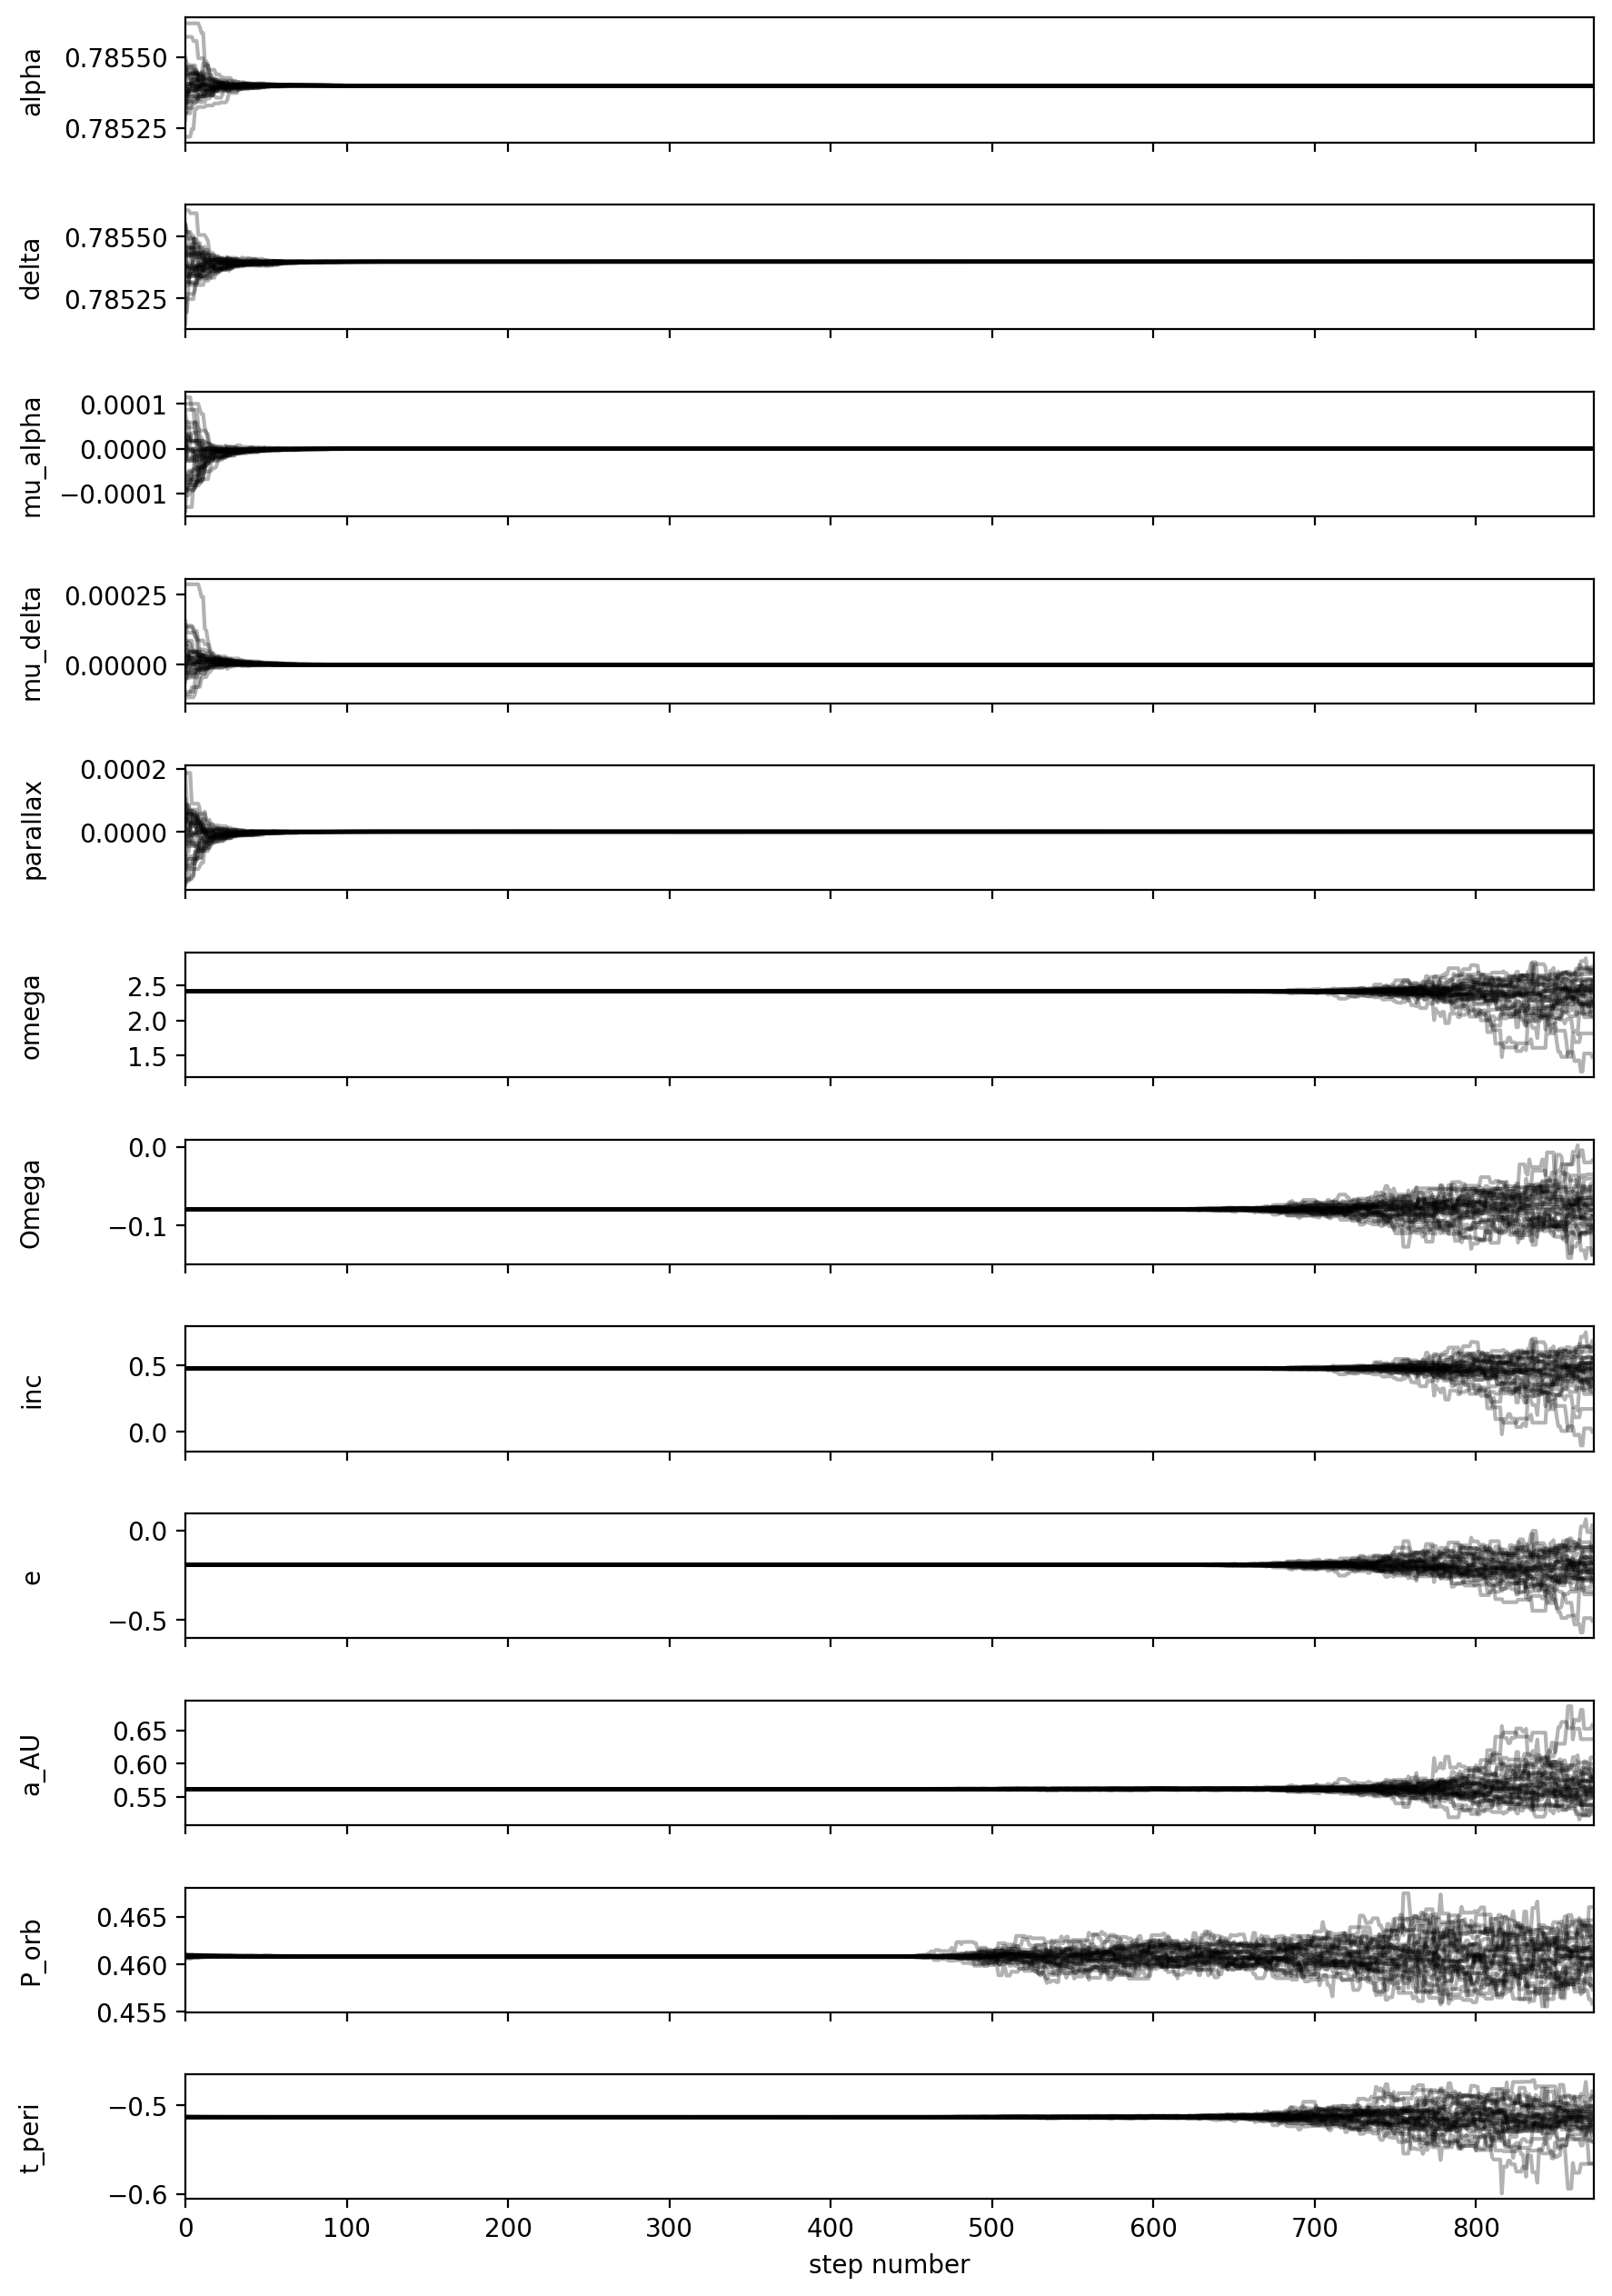

In [26]:
fig, axes = plt.subplots(12, figsize=(10, 15), sharex=True)
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.5, hspace=0.5)

samples = sampler.get_chain()

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(parameters[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

Estimate the integrated autocorrelation

In [27]:
tau = sampler.get_autocorr_time()
print(tau)

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 10 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 17;
tau: [17.06435683 19.62204608 17.65169695 20.47356522 13.24280103 45.37093116
 49.36307452 44.94055286 50.24517589 47.19635015 51.99307588 53.15064523]

Flatten the chain so we have a flat list of samples 

In [28]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(1632, 12)


# Results

Make a corner plot to show MCMC results 

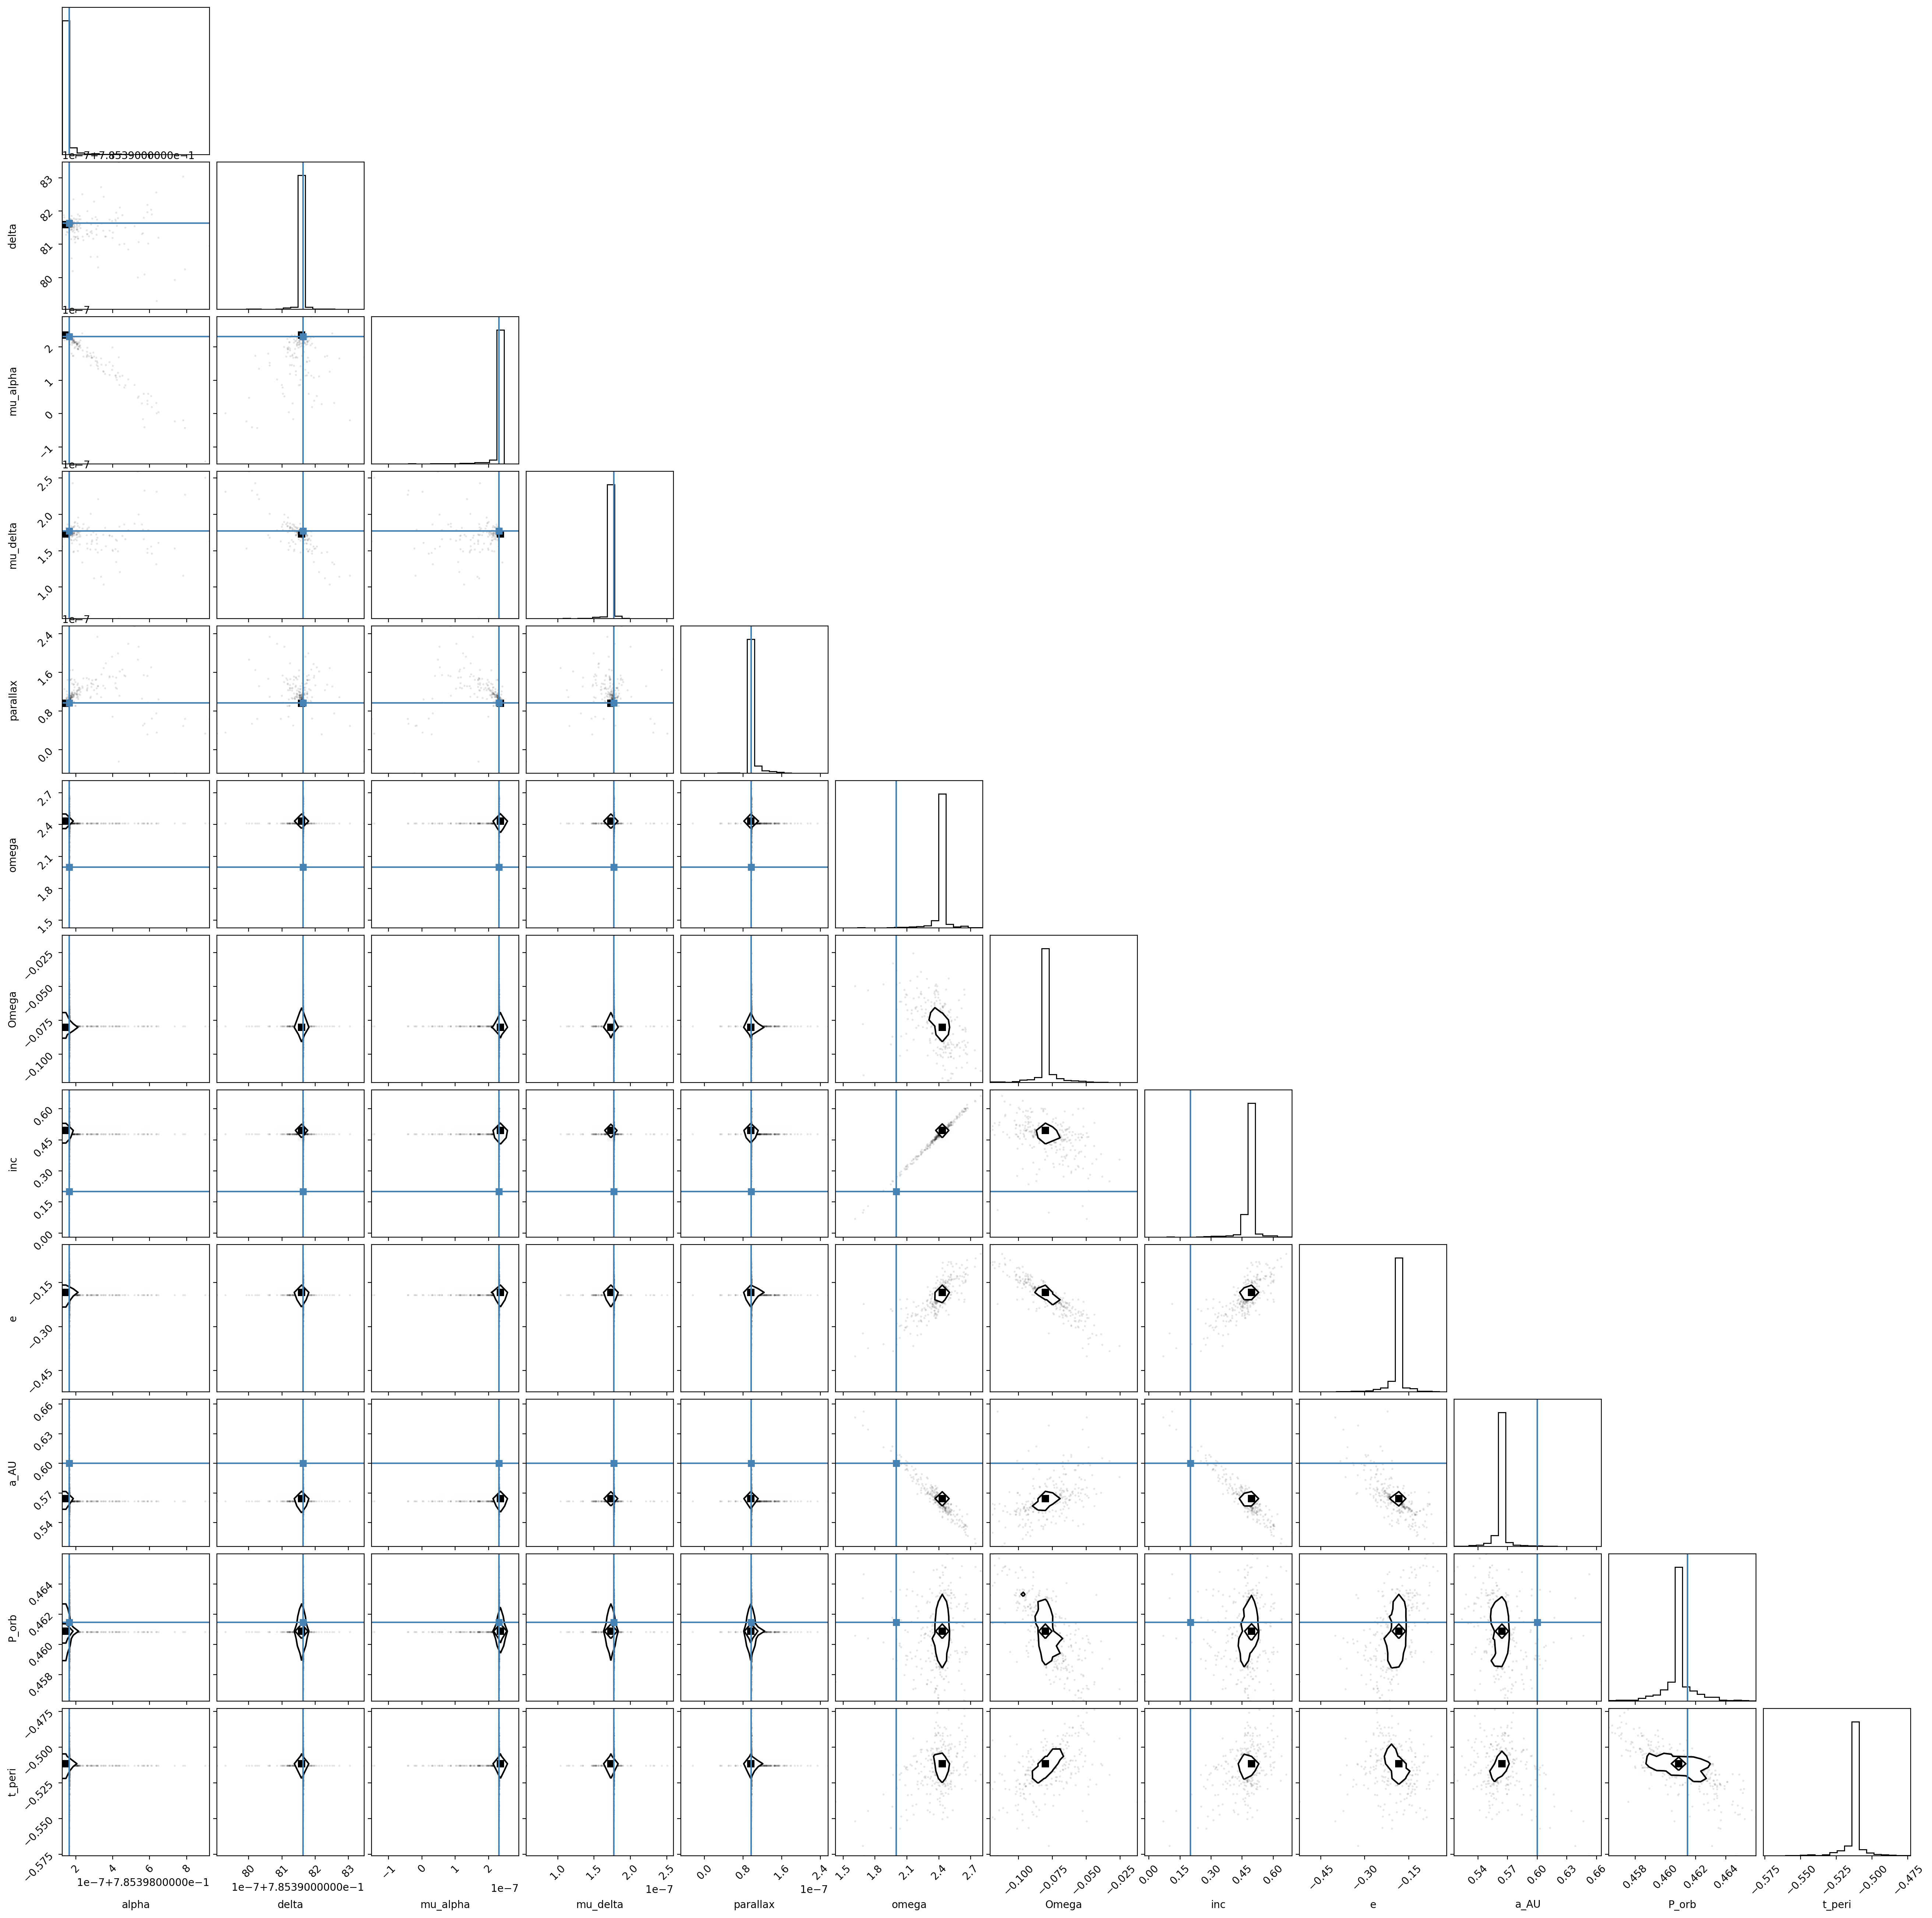

In [30]:
fig = corner.corner(
    flat_samples, labels=parameters, truths=truepars
);